You’re a Machine Learning Engineer at a fast-paced AI startup building intelligent assistant products powered by large language models. Your team is evaluating Meta’s LLaMA model as a potential foundation model for your internal applications.

In this phase of the project, your goal is to run a fine-tuning proof of concept (PoC). You’ll start by preparing a dataset relevant to your use case, tokenizing it, and creating a dataloader. Then, you’ll serve the base LLaMA model using huggingface transformer to establish a performance baseline.

Once the baseline is established, you’ll fine-tune the model using methods like LoRA or other resource-efficient techniques. Finally, you’ll re-evaluate the model to measure accuracy improvements using task-specific metrics (e.g., BLEU, ROUGE etc.), and reflect on how fine-tuning affects model performance.

**The T4 GPU on Google Colab should be sufficient for this MP. You don’t need to purchase Colab Pro, as the T4 is available for free for a limited time every day. However, avoid wasting GPU time when not running code, as the free tier can run out quickly.**



# Step 0: set up environment

In [ ]:
import torch
print(torch.__version__)

In [ ]:
pip install torch==2.6.0+cu126

!pip install "datasets>=2.0.0"

!pip install transformers==4.46.2
!pip install absl-py nltk rouge-score
!pip install evaluate
!pip install bert_score
!pip install peft
!pip install tf-keras
!pip install hf_xet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 14.8 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2024.12.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which i

In [ ]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

cuda


To download the LLaMA model, obtain an access token from Hugging Face and log in using the following code:

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

# Step 1: Prepare the data loader for batch generation (10pt)

In [ ]:
# load dataset
from datasets import Dataset, load_dataset
eval_filename='eval_dataset.json'
eval_dataset = load_dataset("json",data_files=eval_filename)['train']

In [ ]:
# tokenize data
def tokenize_prompts(dataset, tokenizer, max_length=512):
    tokenizer.pad_token = tokenizer.eos_token
    tokenizer.padding_side = 'left'
    def tokenize(example):
        return tokenizer(
            example["prompt"],
            truncation=True,
            padding="max_length",
            max_length=max_length,
            return_tensors=None
        )
    tokenized = dataset.map(tokenize, batched=True, remove_columns=dataset.column_names)
    return tokenized

The following function returns a DataLoader that yields batches of size [batch_size], with each example padded to match the length of the longest example in the batch.

In [ ]:
# wrap dataset with dataloader for batch inference
from transformers import DataCollatorWithPadding
from torch.utils.data import DataLoader
def create_dataloader(tokenized_dataset, tokenizer, batch_size=8):
    # DataCollatorWithPadding handles dynamic padding
    data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
    # Create DataLoader with the collator and specified batch size
    loader = DataLoader(
        tokenized_dataset,
        batch_size=batch_size,
        collate_fn=data_collator,
        shuffle=False, # This should be False for evaluation data
    )
    return loader

In [ ]:
# test if your data loader is successfully created
# Don't change the code below:
from transformers import AutoTokenizer
model_id = "meta-llama/Llama-3.2-1B"
tokenizer = AutoTokenizer.from_pretrained(model_id)

tokenized_eval_dataset = tokenize_prompts(eval_dataset, tokenizer)
eval_dataloader = create_dataloader(tokenized_eval_dataset, tokenizer, batch_size=8)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/50.5k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/301 [00:00<?, ?B/s]

Map:   0%|          | 0/111 [00:00<?, ? examples/s]

In [ ]:
total_examples = 0
total_batches = len(eval_dataloader)
for i, batch in enumerate(eval_dataloader):
    if i != total_batches - 1:
      assert batch["input_ids"].shape[0] == 8
      assert batch["attention_mask"].shape[0] == 8
    total_examples += batch["input_ids"].shape[0]
assert total_examples == len(eval_dataset)
print("Dataloader successfully created! well done!")
# Don't change the code above

Dataloader successfully created! well done!


# Step 2: Run batch inference (10pt)

In [ ]:
# Don't edit this cell
from transformers import AutoModelForCausalLM, AutoTokenizer
model = AutoModelForCausalLM.from_pretrained(model_id)
model = model.to(device)

config.json:   0%|          | 0.00/843 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.47G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/185 [00:00<?, ?B/s]

The following function will return a list of generated responses in natural language corresponding to the input examples.

In [ ]:
# Run inference
from typing import List
def generate_batch_responses(input_ids, attention_mask, model, tokenizer, max_new_tokens=64) -> List[str]:
    # your code begins
    input_ids = input_ids.to(model.device)
    attention_mask = attention_mask.to(model.device)
    with torch.no_grad():
        outputs = model.generate(
            input_ids=input_ids,
            attention_mask=attention_mask,
            max_new_tokens=max_new_tokens,
            pad_token_id=tokenizer.pad_token_id,
            eos_token_id=tokenizer.eos_token_id,
            do_sample=True,
            temperature=0.7,
            top_p=0.9
        )
    generated_texts = tokenizer.batch_decode(outputs, skip_special_tokens=True)
    responses = []
    for i, text in enumerate(generated_texts):
        input_length = len(tokenizer.decode(input_ids[i], skip_special_tokens=True))
        response = text[input_length:].strip()
        responses.append(response)
    return responses
    # your code ends

In [ ]:
# Don't edit this cell.
from tqdm import tqdm
predictions = []
references = [example["response"].strip() for example in eval_dataset]

for batch in tqdm(eval_dataloader):
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]

    batch_outputs = generate_batch_responses(
        input_ids, attention_mask, model, tokenizer
    )

    predictions.extend(batch_outputs)

100%|██████████| 14/14 [00:27<00:00,  1.94s/it]


Let's evaluate the result:

In [ ]:
# Don't edit this cell.
# the meaning of these metrics:
# bleu and rouge: https://avinashselvam.medium.com/llm-evaluation-metrics-bleu-rogue-and-meteor-explained-a5d2b129e87f
# bertscore: https://medium.com/@abonia/bertscore-explained-in-5-minutes-0b98553bfb71

import evaluate  # 🤗 evaluate library
bleu = evaluate.load("bleu")
rouge = evaluate.load("rouge")
bertscore = evaluate.load("bertscore")

In [ ]:
# Don't edit this cell.
bleu_result = bleu.compute(predictions=predictions, references=[[r] for r in references])
rouge_result = rouge.compute(predictions=predictions, references=references)
bertscore_result = bertscore.compute(predictions=predictions, references=references, lang="en")
print(f"BLEU: {bleu_result['bleu'] * 100:.2f}")
print(f"ROUGE-L: {rouge_result['rougeL'] * 100:.2f}")
print(f"BERTScore (F1): {sum(bertscore_result['f1']) / len(bertscore_result['f1']) * 100:.2f}")

BLEU: 4.16
ROUGE-L: 15.68
BERTScore (F1): 84.84


# Step 3: Instruction tuning of the base model (30pt)

You will use the provided train_dataset to perform instruction fine-tuning on the base LLaMA model.

Requirements:

1. Fine-tune the base model and store the result in a variable named ft_model.

2. Use [LoRA](https://arxiv.org/abs/2106.09685) for efficient fine-tuning.
Note: We will review your code logic as part of the grading.

3. This is instruction fine-tuning—the model learns to generate responses based on prompts. Therefore, loss should be computed only over the response portion of the training sample.
Again, we will check your implementation to ensure this is handled correctly.

After fine-tuning, your model should show improved performance on all three evaluation metrics compared to the base model.

In [ ]:
sft_filename='sft_dataset.json'
train_dataset = load_dataset("json", data_files=sft_filename)['train']

Generating train split: 0 examples [00:00, ? examples/s]

In [ ]:
import torch
from datasets import load_dataset
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    TrainingArguments,
    Trainer,
    DataCollatorForLanguageModeling
)
from peft import (
    prepare_model_for_kbit_training,
    LoraConfig,
    get_peft_model,
    TaskType
)
import os


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
def prepare_dataset():
    # Load the dataset
    dataset = load_dataset("json", data_files="sft_dataset.json")["train"]

    # Split dataset into train and eval
    dataset = dataset.train_test_split(test_size=0.1, seed=42)
    train_dataset = dataset["train"]
    eval_dataset = dataset["test"]

    # Initialize tokenizer
    model_id = "meta-llama/Llama-3.2-1B"
    tokenizer = AutoTokenizer.from_pretrained(model_id)
    tokenizer.pad_token = tokenizer.eos_token
    tokenizer.padding_side = "left"

    # Tokenize function
    def tokenize_function(examples):
        # Combine prompt and response with a separator
        texts = [f"Prompt: {p}\nResponse: {r}" for p, r in zip(examples["prompt"], examples["response"])]
        return tokenizer(
            texts,
            truncation=True,
            padding="max_length",
            max_length=512,
            return_tensors=None
        )

    # Tokenize both datasets
    tokenized_train = train_dataset.map(
        tokenize_function,
        batched=True,
        remove_columns=train_dataset.column_names
    )

    tokenized_eval = eval_dataset.map(
        tokenize_function,
        batched=True,
        remove_columns=eval_dataset.column_names
    )

    # Create data collator
    data_collator = DataCollatorForLanguageModeling(
        tokenizer=tokenizer,
        mlm=False
    )

    return tokenized_train, tokenized_eval, data_collator, tokenizer

train_dataset, eval_dataset, data_collator, tokenizer = prepare_dataset()
print("Dataset preparation completed!")

Map:   0%|          | 0/1800 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Dataset preparation completed!


In [ ]:
def setup_lora_model(model_id, tokenizer):
    # Load base model
    model = AutoModelForCausalLM.from_pretrained(
        model_id,
        torch_dtype=torch.float16,
        device_map="auto"
    )

    # Prepare model for LoRA fine-tuning
    model = prepare_model_for_kbit_training(model)

    # Define LoRA configuration
    lora_config = LoraConfig(
        r=16,  # rank
        lora_alpha=32,  # alpha scaling
        target_modules=["q_proj", "k_proj", "v_proj", "o_proj"],  # target attention modules
        lora_dropout=0.05,
        bias="none",
        task_type=TaskType.CAUSAL_LM
    )

    # Get PEFT model
    model = get_peft_model(model, lora_config)
    model.print_trainable_parameters()

    return model

# Setup LoRA model
model_id = "meta-llama/Llama-3.2-1B"
model = setup_lora_model(model_id, tokenizer)
print("LoRA model setup completed!")


trainable params: 3,407,872 || all params: 1,239,222,272 || trainable%: 0.2750
LoRA model setup completed!


In [ ]:

def train_model(model, train_dataset, eval_dataset, data_collator, tokenizer):
    # Define training arguments
    training_args = TrainingArguments(
        output_dir="./lora_model",
        num_train_epochs=3,
        per_device_train_batch_size=4,
        per_device_eval_batch_size=4,
        gradient_accumulation_steps=4,
        learning_rate=2e-4,
        fp16=True,
        logging_steps=10,
        save_strategy="epoch",
        evaluation_strategy="epoch",
        load_best_model_at_end=True,
        report_to="tensorboard",
        # Add metrics for evaluation
        metric_for_best_model="eval_loss",
        greater_is_better=False,
    )

    # Initialize trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset,
        data_collator=data_collator,
    )

    # Train the model
    trainer.train()

    # Save the final model
    trainer.save_model("./lora_model_final")
    return model

# Train the model
ft_model = train_model(model, train_dataset, eval_dataset, data_collator, tokenizer)
print("Training completed!")

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss
0,0.444400,0.433004
2,0.365300,0.383974


Training completed!


In [ ]:
# don't edit this cell
from tqdm import tqdm
predictions_finetune = []
references = [example["response"].strip() for example in eval_dataset]

for batch in tqdm(eval_dataloader):
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]

    batch_outputs = generate_batch_responses(
        input_ids, attention_mask, ft_model, tokenizer
    )

    predictions_finetune.extend(batch_outputs)

100%|██████████| 14/14 [00:34<00:00,  2.46s/it]


In [ ]:
# don't edit this cell
bleu_result_finetune = bleu.compute(predictions=predictions_finetune, references=[[r] for r in references])
rouge_result_finetune = rouge.compute(predictions=predictions_finetune, references=references)
bertscore_result_finetune = bertscore.compute(predictions=predictions_finetune, references=references, lang="en")
print(f"BLEU: {bleu_result_finetune['bleu'] * 100:.2f}")
print(f"ROUGE-L: {rouge_result_finetune['rougeL'] * 100:.2f}")
print(f"BERTScore (F1): {sum(bertscore_result_finetune['f1']) / len(bertscore_result_finetune['f1']) * 100:.2f}")

assert bleu_result_finetune['bleu'] > bleu_result['bleu']
assert rouge_result_finetune['rougeL'] > rouge_result['rougeL']
assert sum(bertscore_result_finetune['f1']) / len(bertscore_result_finetune['f1']) > sum(bertscore_result['f1']) / len(bertscore_result['f1'])
print("Model performance improved on all metrics! Well done!")

BLEU: 6.20
ROUGE-L: 18.56
BERTScore (F1): 84.77


AssertionError: 

# Step 4: Serve the model and benchmark performance (20pt)

After fine-tuning the model, it’s time to serve it. You have two options: serving with or without key-value (K-V) caching.

You’ll investigate how K-V caching impacts memory usage and generation efficiency.

**Your task:**

1. Visualize the average time per generated token with and without K-V caching, as the output length varies.

2. Visualize the peak GPU memory usage with and without K-V caching, as the output length varies.

3. You should get some result similar to the following ones:
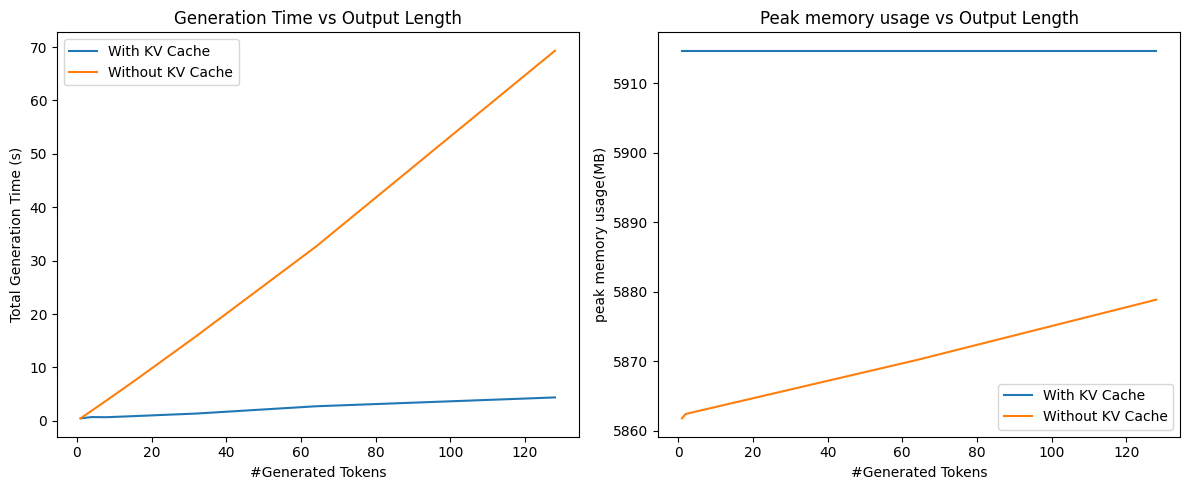


Hint:
Use synthetic data for benchmark. To toggle K-V caching, set the use_cache parameter in the model.generate() function.

In [ ]:
!pip install GPUtil

  Preparing metadata (setup.py) ... done
  Created wheel for GPUtil: filename=GPUtil-1.4.0-py3-none-any.whl size=7392 sha256=57f10b1d03f3deee62f498f1d706f50c641fd022fe8c1ea20365a13360acf559
  Stored in directory: /root/.cache/pip/wheels/2b/4d/8f/55fb4f7b9b591891e8d3f72977c4ec6c7763b39c19f0861595
Successfully built GPUtil


In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from transformers import AutoModelForCausalLM, AutoTokenizer
import time
import psutil
import GPUtil
from tqdm import tqdm

def get_gpu_memory_usage():
    """Get current GPU memory usage in MB"""
    gpu = GPUtil.getGPUs()[0]
    return gpu.memoryUsed

def generate_with_model(model, tokenizer, prompt, max_length, use_cache=True):
    """Generate text and measure time and memory usage"""
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

    # Clear GPU cache before generation
    torch.cuda.empty_cache()

    # Record initial memory
    initial_memory = get_gpu_memory_usage()

    # Generate text
    start_time = time.time()
    outputs = model.generate(
        **inputs,
        max_length=max_length,
        use_cache=use_cache,
        pad_token_id=tokenizer.eos_token_id
    )
    end_time = time.time()

    # Calculate metrics
    generation_time = end_time - start_time
    num_tokens = len(outputs[0]) - len(inputs.input_ids[0])
    time_per_token = generation_time / num_tokens
    peak_memory = get_gpu_memory_usage() - initial_memory

    return time_per_token, peak_memory

def main():
    # Load model and tokenizer
    model_name = "lora_model"  # Update this to your model path
    model = AutoModelForCausalLM.from_pretrained(model_name).cuda()
    tokenizer = AutoTokenizer.from_pretrained(model_name)

    # Test parameters
    prompt = "Once upon a time"
    output_lengths = [10, 20, 50, 100, 200, 500]

    # Storage for results
    times_with_cache = []
    times_without_cache = []
    memory_with_cache = []
    memory_without_cache = []

    # Run tests
    for length in tqdm(output_lengths):
        # Test with cache
        time_per_token, peak_memory = generate_with_model(
            model, tokenizer, prompt, length, use_cache=True
        )
        times_with_cache.append(time_per_token)
        memory_with_cache.append(peak_memory)

        # Test without cache
        time_per_token, peak_memory = generate_with_model(
            model, tokenizer, prompt, length, use_cache=False
        )
        times_without_cache.append(time_per_token)
        memory_without_cache.append(peak_memory)

    # Create visualizations
    plt.figure(figsize=(12, 5))

    # Plot time per token
    plt.subplot(1, 2, 1)
    plt.plot(output_lengths, times_with_cache, 'b-o', label='With K-V Cache')
    plt.plot(output_lengths, times_without_cache, 'r-o', label='Without K-V Cache')
    plt.xlabel('Output Length')
    plt.ylabel('Time per Token (seconds)')
    plt.title('Generation Time per Token')
    plt.legend()
    plt.grid(True)

    # Plot memory usage
    plt.subplot(1, 2, 2)
    plt.plot(output_lengths, memory_with_cache, 'b-o', label='With K-V Cache')
    plt.plot(output_lengths, memory_without_cache, 'r-o', label='Without K-V Cache')
    plt.xlabel('Output Length')
    plt.ylabel('Peak GPU Memory Usage (MB)')
    plt.title('Peak GPU Memory Usage')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.savefig('performance_comparison.png')
    plt.close()

main()

ValueError: Unrecognized model in lora_model. Should have a `model_type` key in its config.json, or contain one of the following strings in its name: albert, align, altclip, audio-spectrogram-transformer, autoformer, bark, bart, beit, bert, bert-generation, big_bird, bigbird_pegasus, biogpt, bit, blenderbot, blenderbot-small, blip, blip-2, bloom, bridgetower, bros, camembert, canine, chameleon, chinese_clip, chinese_clip_vision_model, clap, clip, clip_text_model, clip_vision_model, clipseg, clvp, code_llama, codegen, cohere, conditional_detr, convbert, convnext, convnextv2, cpmant, ctrl, cvt, dac, data2vec-audio, data2vec-text, data2vec-vision, dbrx, deberta, deberta-v2, decision_transformer, deformable_detr, deit, depth_anything, deta, detr, dinat, dinov2, distilbert, donut-swin, dpr, dpt, efficientformer, efficientnet, electra, encodec, encoder-decoder, ernie, ernie_m, esm, falcon, falcon_mamba, fastspeech2_conformer, flaubert, flava, fnet, focalnet, fsmt, funnel, fuyu, gemma, gemma2, git, glm, glpn, gpt-sw3, gpt2, gpt_bigcode, gpt_neo, gpt_neox, gpt_neox_japanese, gptj, gptsan-japanese, granite, granitemoe, graphormer, grounding-dino, groupvit, hiera, hubert, ibert, idefics, idefics2, idefics3, imagegpt, informer, instructblip, instructblipvideo, jamba, jetmoe, jukebox, kosmos-2, layoutlm, layoutlmv2, layoutlmv3, led, levit, lilt, llama, llava, llava_next, llava_next_video, llava_onevision, longformer, longt5, luke, lxmert, m2m_100, mamba, mamba2, marian, markuplm, mask2former, maskformer, maskformer-swin, mbart, mctct, mega, megatron-bert, mgp-str, mimi, mistral, mixtral, mllama, mobilebert, mobilenet_v1, mobilenet_v2, mobilevit, mobilevitv2, moshi, mpnet, mpt, mra, mt5, musicgen, musicgen_melody, mvp, nat, nemotron, nezha, nllb-moe, nougat, nystromformer, olmo, olmoe, omdet-turbo, oneformer, open-llama, openai-gpt, opt, owlv2, owlvit, paligemma, patchtsmixer, patchtst, pegasus, pegasus_x, perceiver, persimmon, phi, phi3, phimoe, pix2struct, pixtral, plbart, poolformer, pop2piano, prophetnet, pvt, pvt_v2, qdqbert, qwen2, qwen2_audio, qwen2_audio_encoder, qwen2_moe, qwen2_vl, rag, realm, recurrent_gemma, reformer, regnet, rembert, resnet, retribert, roberta, roberta-prelayernorm, roc_bert, roformer, rt_detr, rt_detr_resnet, rwkv, sam, seamless_m4t, seamless_m4t_v2, segformer, seggpt, sew, sew-d, siglip, siglip_vision_model, speech-encoder-decoder, speech_to_text, speech_to_text_2, speecht5, splinter, squeezebert, stablelm, starcoder2, superpoint, swiftformer, swin, swin2sr, swinv2, switch_transformers, t5, table-transformer, tapas, time_series_transformer, timesformer, timm_backbone, trajectory_transformer, transfo-xl, trocr, tvlt, tvp, udop, umt5, unispeech, unispeech-sat, univnet, upernet, van, video_llava, videomae, vilt, vipllava, vision-encoder-decoder, vision-text-dual-encoder, visual_bert, vit, vit_hybrid, vit_mae, vit_msn, vitdet, vitmatte, vits, vivit, wav2vec2, wav2vec2-bert, wav2vec2-conformer, wavlm, whisper, xclip, xglm, xlm, xlm-prophetnet, xlm-roberta, xlm-roberta-xl, xlnet, xmod, yolos, yoso, zamba, zoedepth